# Multi-language Classification



## Model choices 

**1. XLM-RoBERTa (`FacebookAI/xlm-roberta-base`)**
- **Purpose**: Cross-lingual language model specifically designed for multilingual tasks
- **Training**: Trained on 100+ languages using CommonCrawl data
- **Strengths**: Excellent cross-lingual transfer, no language-specific tokens needed
- **Use case**: Often considered the gold standard for multilingual classification

**2. Multilingual BERT (`google-bert/bert-base-multilingual-cased`)**
- **Purpose**: The original multilingual transformer model
- **Training**: Trained on Wikipedia in 104 languages
- **Strengths**: Well-established baseline, good performance across languages
- **Use case**: Benchmark comparison - see how newer models compare to this classic

**3. DistilBERT Multilingual (`distilbert/distilbert-base-multilingual-cased`)**
- **Purpose**: Lighter, faster version of multilingual BERT
- **Training**: Distilled from mBERT - 40% smaller, 60% faster
- **Strengths**: Good performance with much lower computational cost
- **Use case**: When you need efficiency without sacrificing too much accuracy


This selection gives you a good spectrum:
- **Performance range**: From efficient (DistilBERT) to state-of-the-art (mDeBERTa-v3 & RemBERT)
- **Model sizes**: Different parameter counts for resource consideration
- **Training approaches**: Different multilingual training strategies
- **Benchmarking**: Compare against established baselines (mBERT) and current SOTA


In [2]:
import os
import random
from dotenv import load_dotenv

from collections import Counter

import pandas as pd
from tqdm import tqdm
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DebertaV2Tokenizer,
)
from huggingface_hub import login

# Model Evaluation Setup
import torch
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)

# Detailed EDA with visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException


DATASET_ID = "minhleduc/multilang-classify-dataset-02"
MODEL_NAMES = {
    "xlm-roberta": "FacebookAI/xlm-roberta-base",
    "mbert": "google-bert/bert-base-multilingual-cased",
    "distilbert-multilingual": "distilbert/distilbert-base-multilingual-cased",
    "deberta-v3": "microsoft/mdeberta-v3-base",
    "rembert": "google/rembert",
}


load_dotenv()
login(token=os.getenv("HF_TOKEN"))


# Set up the plotting style
plt.style.use("default")
sns.set_palette("husl")
fig_size = (12, 8)

/home/octoopt/workspace/projects/learn-from-basics/nlp_learning/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


# EDA

In [3]:
# Load the dataset
dataset = load_dataset(DATASET_ID)
print("Dataset structure:")
print(dataset)
print("\nDataset info:")
print(f"Number of splits: {len(dataset)}")
for split_name, split_data in dataset.items():
    print(f"{split_name}: {len(split_data)} examples")

# Show first few examples
print("\nFirst 3 examples from train split:")
for i in range(min(3, len(dataset["train"]))):
    print(f"Example {i + 1}:")
    example = dataset["train"][i]
    for key, value in example.items():
        if isinstance(value, str) and len(value) > 100:
            print(f"  {key}: {value[:100]}...")
        else:
            print(f"  {key}: {value}")
    print()

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['Language', 'Text'],
        num_rows: 83358
    })
    validation: Dataset({
        features: ['Language', 'Text'],
        num_rows: 17862
    })
    test: Dataset({
        features: ['Language', 'Text'],
        num_rows: 17863
    })
})

Dataset info:
Number of splits: 3
train: 83358 examples
validation: 17862 examples
test: 17863 examples

First 3 examples from train split:
Example 1:
  Language: 28
  Text: wa wa nasaha walevi could ya wagonjwa wa wamelewa wamelewa

Example 2:
  Language: 35
  Text: vĩnh viễn quảng cáo tỷ lệ tăng trưởng gdp sẽ yêu cầu bao giờ tăng các lượt chia sẻ tương đối của lưu...

Example 3:
  Language: 33
  Text: özellikle şehrin en ünlü sakinleri olan geyşa nın son eğitim merkezi olarak ünlü



Starting comprehensive EDA...
LANGUAGE DISTRIBUTION ANALYSIS

TRAIN Split:
Total examples: 83358
Number of unique languages: 36
Most common languages:
  Language 5: 4816 (5.78%)
  Language 7: 4535 (5.44%)
  Language 27: 4412 (5.29%)
  Language 26: 4192 (5.03%)
  Language 0: 4084 (4.90%)

VALIDATION Split:
Total examples: 17862
Number of unique languages: 36
Most common languages:
  Language 5: 1032 (5.78%)
  Language 7: 971 (5.44%)
  Language 27: 945 (5.29%)
  Language 26: 898 (5.03%)
  Language 0: 875 (4.90%)

TEST Split:
Total examples: 17863
Number of unique languages: 36
Most common languages:
  Language 5: 1032 (5.78%)
  Language 7: 972 (5.44%)
  Language 27: 946 (5.30%)
  Language 26: 898 (5.03%)
  Language 0: 876 (4.90%)


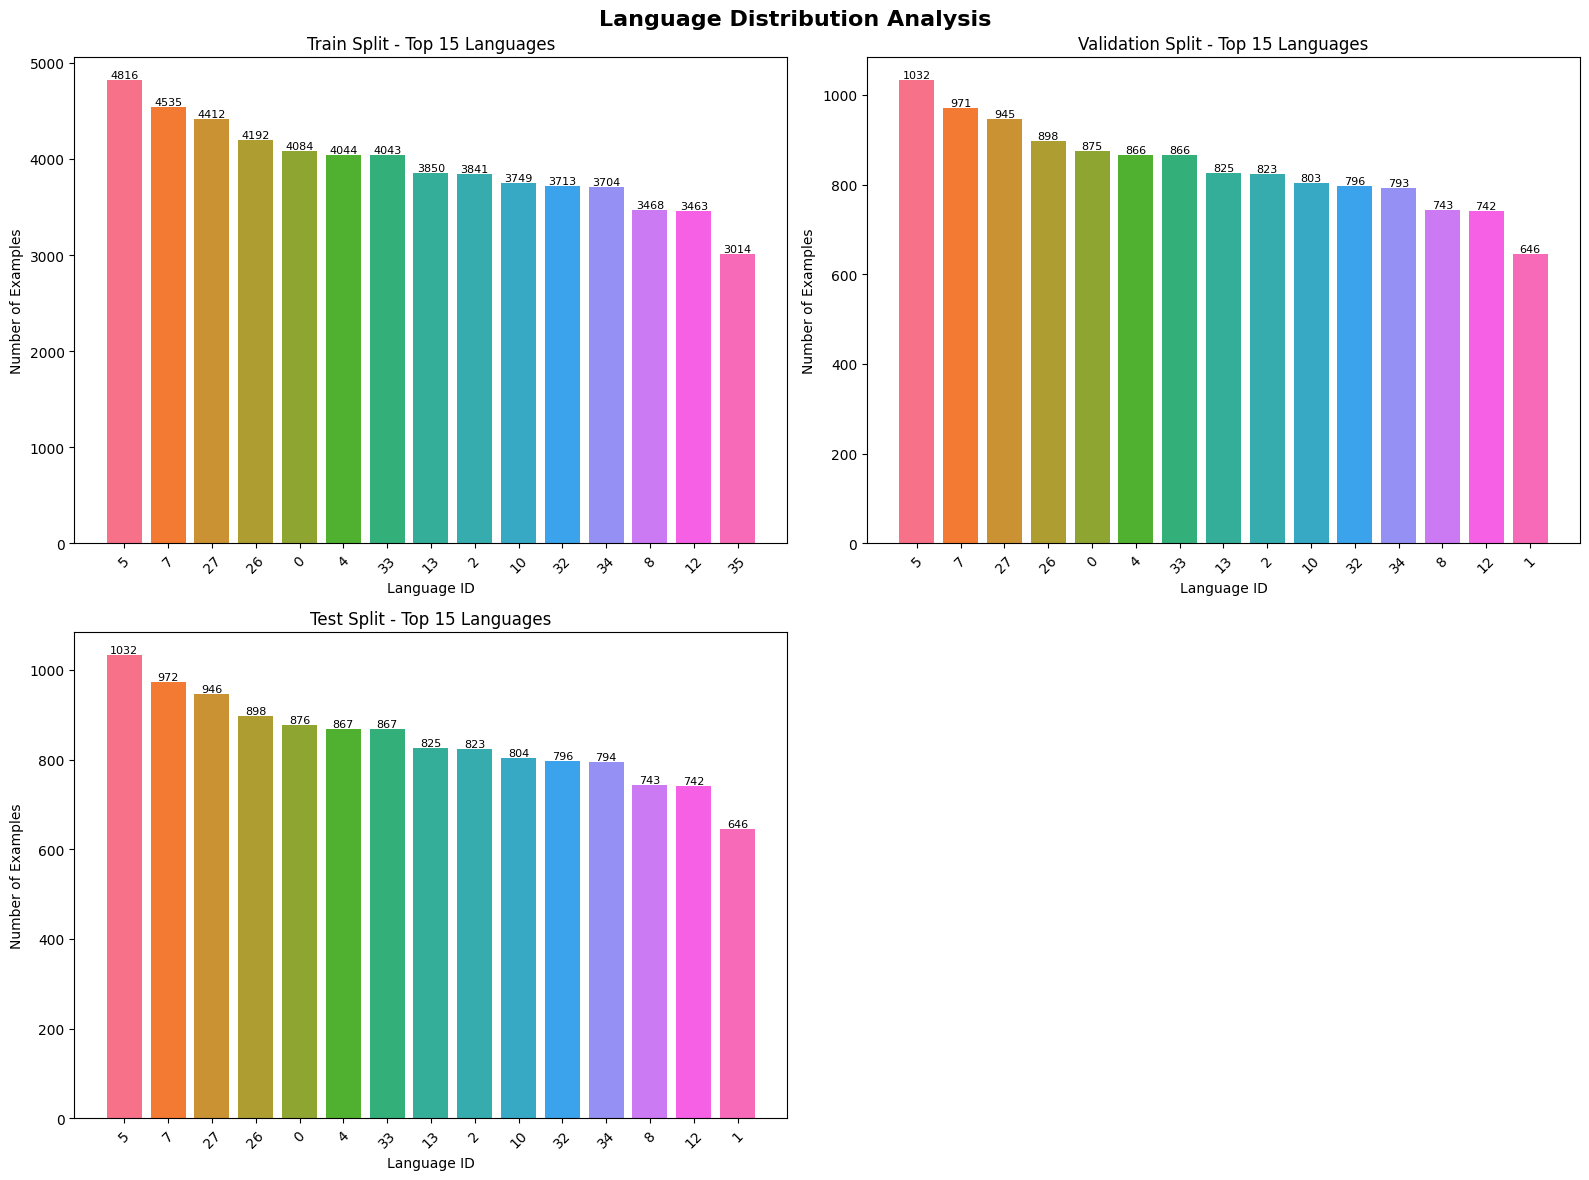

In [9]:
def analyze_language_distribution(dataset):
    """Analyze and visualize language distribution"""
    print("=" * 60)
    print("LANGUAGE DISTRIBUTION ANALYSIS")
    print("=" * 60)

    # Create subplot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle("Language Distribution Analysis", fontsize=16, fontweight="bold")

    for idx, (split_name, split_data) in enumerate(dataset.items()):
        languages = split_data["Language"]
        lang_counts = Counter(languages)

        # Print statistics
        print(f"\n{split_name.upper()} Split:")
        print(f"Total examples: {len(languages)}")
        print(f"Number of unique languages: {len(lang_counts)}")
        print(f"Most common languages:")
        for lang, count in lang_counts.most_common(5):
            percentage = (count / len(languages)) * 100
            print(f"  Language {lang}: {count} ({percentage:.2f}%)")

        if idx < 3:  # Only plot for train, validation, test
            ax = axes[idx // 2, idx % 2]

            # Plot top 15 languages for better readability
            top_langs = dict(lang_counts.most_common(15))

            bars = ax.bar(
                range(len(top_langs)),
                list(top_langs.values()),
                color=sns.color_palette("husl", len(top_langs)),
            )
            ax.set_title(f"{split_name.capitalize()} Split - Top 15 Languages")
            ax.set_xlabel("Language ID")
            ax.set_ylabel("Number of Examples")
            ax.set_xticks(range(len(top_langs)))
            ax.set_xticklabels(list(top_langs.keys()), rotation=45)

            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2.0,
                    height,
                    f"{int(height)}",
                    ha="center",
                    va="bottom",
                    fontsize=8,
                )

    # Remove the unused subplot
    axes[1, 1].remove()

    plt.tight_layout()
    plt.show()

    return lang_counts


# Run all analyses
print("Starting comprehensive EDA...")
lang_counts = analyze_language_distribution(dataset)


TEXT LENGTH ANALYSIS

TRAIN Split:
Character length - Mean: 147.2, Median: 100.0
Character length - Min: 1, Max: 12160
Word count - Mean: 24.6, Median: 17.0
Word count - Min: 1, Max: 3497

VALIDATION Split:
Character length - Mean: 147.2, Median: 99.0
Character length - Min: 0, Max: 5565
Word count - Mean: 24.6, Median: 16.0
Word count - Min: 0, Max: 1765

TEST Split:
Character length - Mean: 145.8, Median: 100.0
Character length - Min: 3, Max: 2647
Word count - Mean: 24.4, Median: 16.0
Word count - Min: 1, Max: 730


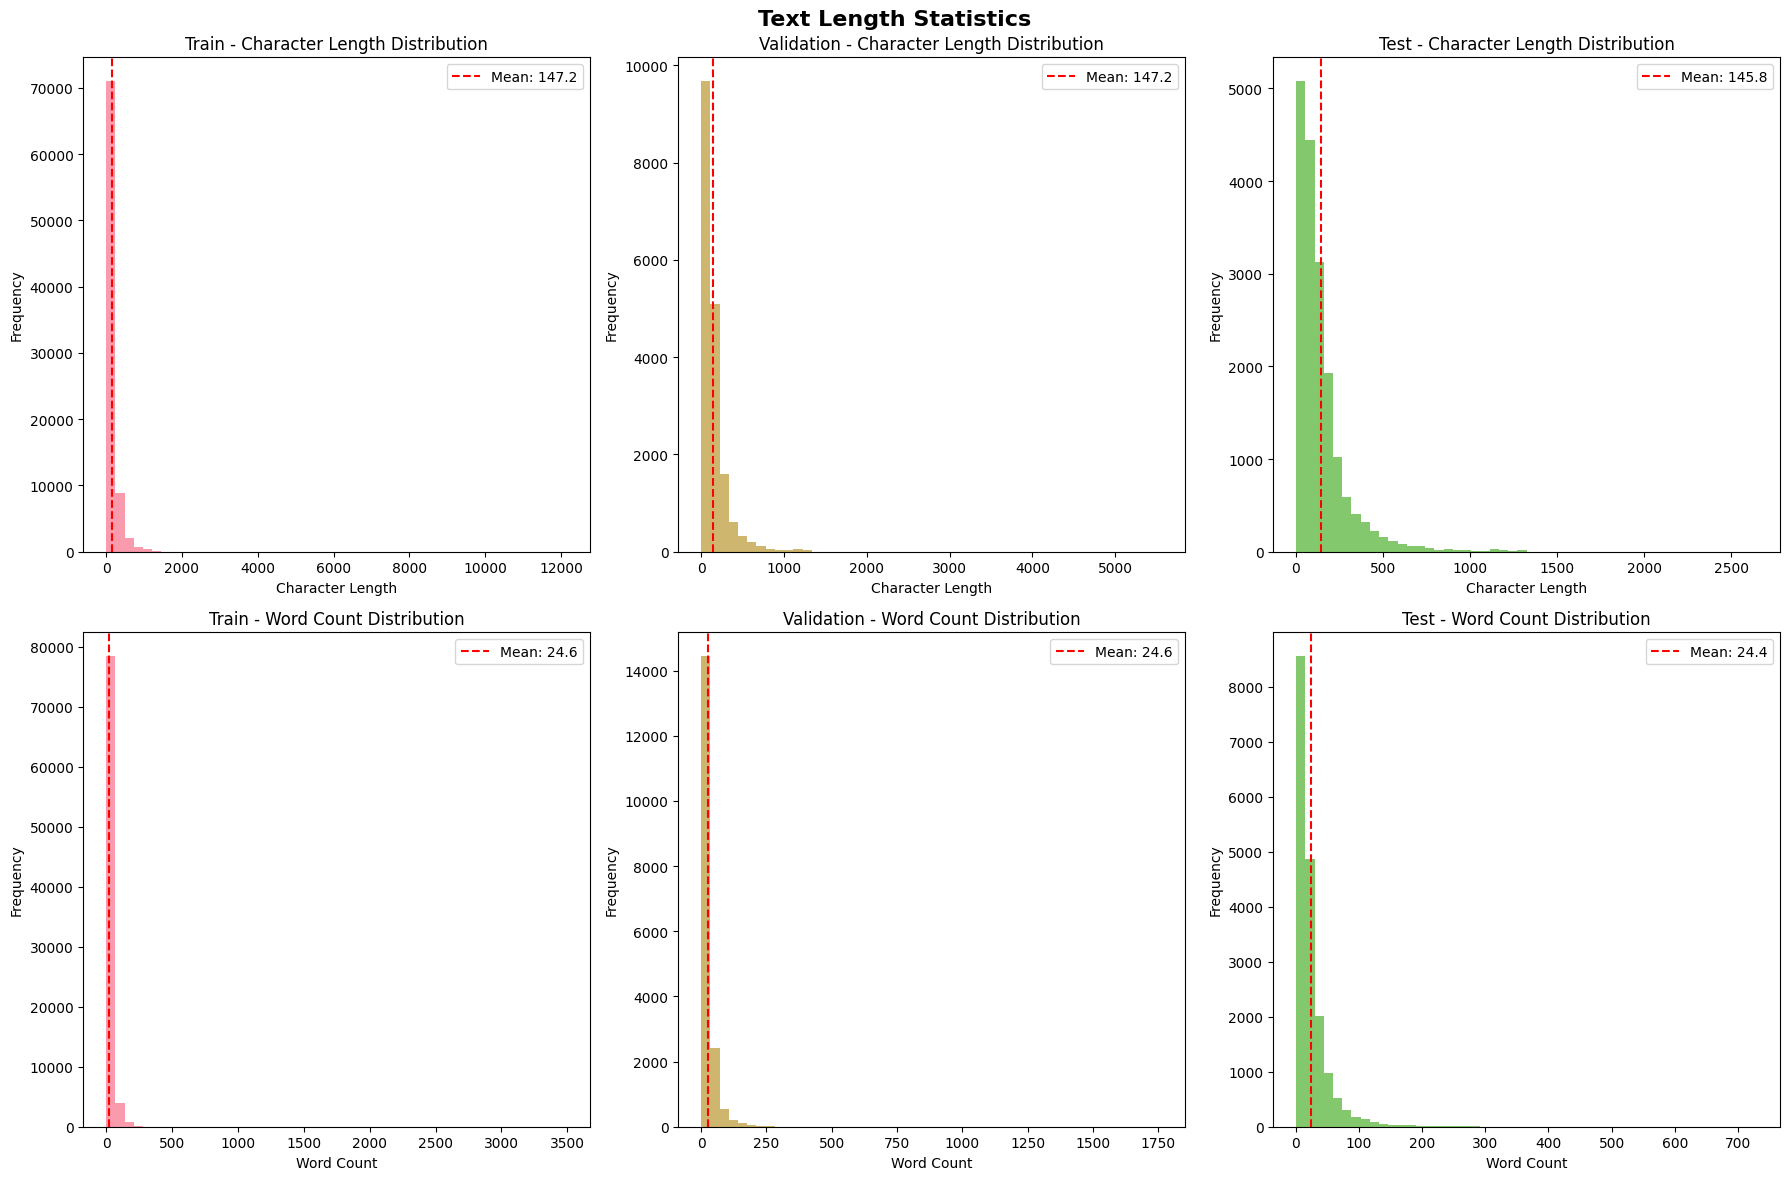

In [10]:
def analyze_text_statistics_with_charts(dataset):
    """Analyze text statistics with visualizations"""
    print("\n" + "=" * 60)
    print("TEXT LENGTH ANALYSIS")
    print("=" * 60)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle("Text Length Statistics", fontsize=16, fontweight="bold")

    all_stats = {}

    for idx, (split_name, split_data) in enumerate(dataset.items()):
        texts = split_data["Text"]

        # Calculate statistics
        char_lengths = [len(text) for text in texts]
        word_counts = [len(text.split()) for text in texts]

        all_stats[split_name] = {
            "char_lengths": char_lengths,
            "word_counts": word_counts,
        }

        # Print statistics
        print(f"\n{split_name.upper()} Split:")
        print(
            f"Character length - Mean: {np.mean(char_lengths):.1f}, Median: {np.median(char_lengths):.1f}"
        )
        print(f"Character length - Min: {min(char_lengths)}, Max: {max(char_lengths)}")
        print(
            f"Word count - Mean: {np.mean(word_counts):.1f}, Median: {np.median(word_counts):.1f}"
        )
        print(f"Word count - Min: {min(word_counts)}, Max: {max(word_counts)}")

        if idx < 3:  # Plot for train, validation, test
            # Character length histogram
            ax1 = axes[0, idx]
            ax1.hist(
                char_lengths, bins=50, alpha=0.7, color=sns.color_palette("husl")[idx]
            )
            ax1.set_title(f"{split_name.capitalize()} - Character Length Distribution")
            ax1.set_xlabel("Character Length")
            ax1.set_ylabel("Frequency")
            ax1.axvline(
                np.mean(char_lengths),
                color="red",
                linestyle="--",
                label=f"Mean: {np.mean(char_lengths):.1f}",
            )
            ax1.legend()

            # Word count histogram
            ax2 = axes[1, idx]
            ax2.hist(
                word_counts, bins=50, alpha=0.7, color=sns.color_palette("husl")[idx]
            )
            ax2.set_title(f"{split_name.capitalize()} - Word Count Distribution")
            ax2.set_xlabel("Word Count")
            ax2.set_ylabel("Frequency")
            ax2.axvline(
                np.mean(word_counts),
                color="red",
                linestyle="--",
                label=f"Mean: {np.mean(word_counts):.1f}",
            )
            ax2.legend()

    plt.tight_layout()
    plt.show()

    return all_stats


text_stats = analyze_text_statistics_with_charts(dataset)


LANGUAGE vs TEXT LENGTH CORRELATION


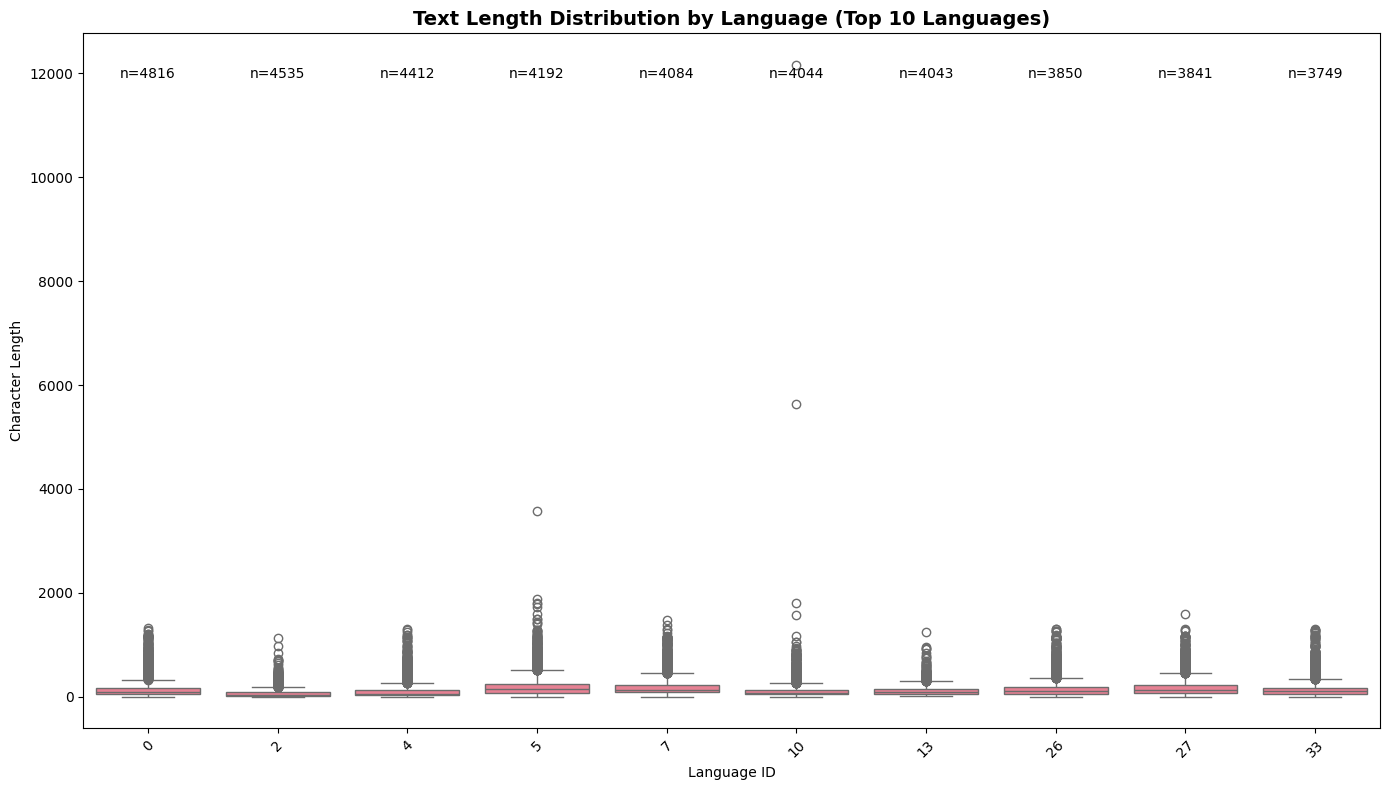

Text length statistics by language (top 10):
            mean     std  count
Language                       
0         144.78  168.33   4084
1         107.16   72.72   3013
2          74.83   86.81   3841
3          89.82   87.26    295
4         115.83  143.12   4044
5         201.10  202.43   4816
6         302.94  202.98    699
7         188.89  173.57   4535
8         187.39  174.85   3468
9         103.40   88.22    250


In [11]:
def create_language_text_length_correlation(dataset):
    """Analyze relationship between languages and text lengths"""
    print("\n" + "=" * 60)
    print("LANGUAGE vs TEXT LENGTH CORRELATION")
    print("=" * 60)

    # Use train split for this analysis
    train_data = dataset["train"]
    languages = train_data["Language"]
    texts = train_data["Text"]
    char_lengths = [len(text) for text in texts]

    # Create DataFrame for easier analysis

    df = pd.DataFrame({"Language": languages, "Text_Length": char_lengths})

    # Get top 10 most frequent languages for better visualization
    top_languages = df["Language"].value_counts().head(10).index
    df_top = df[df["Language"].isin(top_languages)]

    # Create box plot
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df_top, x="Language", y="Text_Length")
    plt.title(
        "Text Length Distribution by Language (Top 10 Languages)",
        fontsize=14,
        fontweight="bold",
    )
    plt.xlabel("Language ID")
    plt.ylabel("Character Length")
    plt.xticks(rotation=45)

    # Add sample size annotations
    for i, lang in enumerate(top_languages):
        sample_size = len(df_top[df_top["Language"] == lang])
        plt.text(
            i,
            plt.gca().get_ylim()[1] * 0.95,
            f"n={sample_size}",
            ha="center",
            va="top",
            fontsize=10,
        )

    plt.tight_layout()
    plt.show()

    # Print correlation statistics
    lang_stats = (
        df.groupby("Language")["Text_Length"].agg(["mean", "std", "count"]).round(2)
    )
    print("Text length statistics by language (top 10):")
    print(lang_stats.head(10).to_string())


create_language_text_length_correlation(dataset)

In [4]:
# Create language ID to name mapping
def create_language_mapping(dataset, sample_size=10):
    """Create a mapping from language IDs to language names using language detection"""

    print("🔍 Creating language ID to name mapping...")

    from langdetect import detect, DetectorFactory

    DetectorFactory.seed = 0

    # Language code to full name mapping
    LANGUAGE_NAMES = {
        "af": "Afrikaans",
        "ar": "Arabic",
        "bg": "Bulgarian",
        "bn": "Bengali",
        "ca": "Catalan",
        "cs": "Czech",
        "cy": "Welsh",
        "da": "Danish",
        "de": "German",
        "el": "Greek",
        "en": "English",
        "es": "Spanish",
        "et": "Estonian",
        "fa": "Persian",
        "fi": "Finnish",
        "fr": "French",
        "gu": "Gujarati",
        "he": "Hebrew",
        "hi": "Hindi",
        "hr": "Croatian",
        "hu": "Hungarian",
        "id": "Indonesian",
        "it": "Italian",
        "ja": "Japanese",
        "kn": "Kannada",
        "ko": "Korean",
        "lt": "Lithuanian",
        "lv": "Latvian",
        "mk": "Macedonian",
        "ml": "Malayalam",
        "mr": "Marathi",
        "ne": "Nepali",
        "nl": "Dutch",
        "no": "Norwegian",
        "pa": "Punjabi",
        "pl": "Polish",
        "pt": "Portuguese",
        "ro": "Romanian",
        "ru": "Russian",
        "sk": "Slovak",
        "sl": "Slovenian",
        "so": "Somali",
        "sq": "Albanian",
        "sv": "Swedish",
        "sw": "Swahili",
        "ta": "Tamil",
        "te": "Telugu",
        "th": "Thai",
        "tl": "Filipino",
        "tr": "Turkish",
        "uk": "Ukrainian",
        "ur": "Urdu",
        "vi": "Vietnamese",
        "zh-cn": "Chinese (Simplified)",
        "zh-tw": "Chinese (Traditional)",
    }

    train_data = dataset["train"]
    language_mapping = {}

    # Get unique language IDs
    unique_lang_ids = sorted(list(set(train_data["Language"])))

    print(f"Found {len(unique_lang_ids)} unique language IDs")
    print("Detecting languages...")

    # For each language ID, sample some texts and detect language
    for lang_id in tqdm(unique_lang_ids, desc="Processing languages"):
        # Get texts for this language ID
        texts_for_lang = [
            text
            for i, text in enumerate(train_data["Text"])
            if train_data["Language"][i] == lang_id
        ]

        # Sample some texts for detection
        sample_texts = texts_for_lang[:sample_size]

        detected_languages = []
        for text in sample_texts:
            try:
                detected_lang = detect(text)
                detected_languages.append(detected_lang)
            except:
                continue

        if detected_languages:
            # Get most common detected language
            most_common_lang = Counter(detected_languages).most_common(1)[0][0]

            # Map to full name
            full_name = LANGUAGE_NAMES.get(
                most_common_lang, f"Unknown ({most_common_lang})"
            )
            language_mapping[lang_id] = {
                "code": most_common_lang,
                "name": full_name,
                "confidence": detected_languages.count(most_common_lang)
                / len(detected_languages),
            }
        else:
            language_mapping[lang_id] = {
                "code": "unknown",
                "name": f"Unknown Language {lang_id}",
                "confidence": 0.0,
            }

    return language_mapping


# Create the mapping
language_id_to_name = create_language_mapping(dataset)

# Display the mapping
print(f"\n{'=' * 60}")
print("LANGUAGE ID MAPPING")
print(f"{'=' * 60}")
print(f"{'ID':<4} {'Code':<6} {'Language Name':<25} {'Confidence':<10}")
print("-" * 60)

for lang_id in sorted(language_id_to_name.keys()):
    info = language_id_to_name[lang_id]
    print(f"{lang_id:<4} {info['code']:<6} {info['name']:<25} {info['confidence']:.2f}")

# Show some examples with detected names
print(f"\n{'=' * 60}")
print("SAMPLE TEXTS WITH DETECTED LANGUAGE NAMES")
print(f"{'=' * 60}")

for i in range(5):
    example = dataset["train"][i]
    lang_id = example["Language"]
    text = example["Text"]
    lang_info = language_id_to_name[lang_id]

    print(f"\\nExample {i + 1}:")
    print(f"  Language ID: {lang_id}")
    print(f"  Detected Language: {lang_info['name']} ({lang_info['code']})")
    print(f"  Confidence: {lang_info['confidence']:.2f}")
    print(f"  Text: {text[:100]}{'...' if len(text) > 100 else ''}")

🔍 Creating language ID to name mapping...
Found 36 unique language IDs
Detecting languages...


Processing languages: 100%|██████████| 36/36 [20:33<00:00, 34.26s/it]


LANGUAGE ID MAPPING
ID   Code   Language Name             Confidence
------------------------------------------------------------
0    ar     Arabic                    1.00
1    bg     Bulgarian                 1.00
2    zh-cn  Chinese (Simplified)      0.90
3    da     Danish                    0.90
4    nl     Dutch                     0.90
5    en     English                   1.00
6    et     Estonian                  1.00
7    fr     French                    1.00
8    de     German                    1.00
9    el     Greek                     1.00
10   hi     Hindi                     1.00
11   id     Indonesian                1.00
12   it     Italian                   0.90
13   ja     Japanese                  1.00
14   kn     Kannada                   1.00
15   ko     Korean                    1.00
16   it     Italian                   0.40
17   ml     Malayalam                 1.00
18   el     Greek                     1.00
19   fa     Persian                   0.90
20   pl  

In [5]:
language_id_to_name

{0: {'code': 'ar', 'name': 'Arabic', 'confidence': 1.0},
 1: {'code': 'bg', 'name': 'Bulgarian', 'confidence': 1.0},
 2: {'code': 'zh-cn', 'name': 'Chinese (Simplified)', 'confidence': 0.9},
 3: {'code': 'da', 'name': 'Danish', 'confidence': 0.9},
 4: {'code': 'nl', 'name': 'Dutch', 'confidence': 0.9},
 5: {'code': 'en', 'name': 'English', 'confidence': 1.0},
 6: {'code': 'et', 'name': 'Estonian', 'confidence': 1.0},
 7: {'code': 'fr', 'name': 'French', 'confidence': 1.0},
 8: {'code': 'de', 'name': 'German', 'confidence': 1.0},
 9: {'code': 'el', 'name': 'Greek', 'confidence': 1.0},
 10: {'code': 'hi', 'name': 'Hindi', 'confidence': 1.0},
 11: {'code': 'id', 'name': 'Indonesian', 'confidence': 1.0},
 12: {'code': 'it', 'name': 'Italian', 'confidence': 0.9},
 13: {'code': 'ja', 'name': 'Japanese', 'confidence': 1.0},
 14: {'code': 'kn', 'name': 'Kannada', 'confidence': 1.0},
 15: {'code': 'ko', 'name': 'Korean', 'confidence': 1.0},
 16: {'code': 'it', 'name': 'Italian', 'confidence': 0

LANGUAGE DISTRIBUTION ANALYSIS (WITH NAMES)

TRAIN Split:
Total examples: 83358
Number of unique languages: 36
Most common languages:
  English (ID 5): 4816 (5.78%)
  French (ID 7): 4535 (5.44%)
  Spanish (ID 27): 4412 (5.29%)
  Russian (ID 26): 4192 (5.03%)
  Arabic (ID 0): 4084 (4.90%)

VALIDATION Split:
Total examples: 17862
Number of unique languages: 36
Most common languages:
  English (ID 5): 1032 (5.78%)
  French (ID 7): 971 (5.44%)
  Spanish (ID 27): 945 (5.29%)
  Russian (ID 26): 898 (5.03%)
  Arabic (ID 0): 875 (4.90%)

TEST Split:
Total examples: 17863
Number of unique languages: 36
Most common languages:
  English (ID 5): 1032 (5.78%)
  French (ID 7): 972 (5.44%)
  Spanish (ID 27): 946 (5.30%)
  Russian (ID 26): 898 (5.03%)
  Arabic (ID 0): 876 (4.90%)


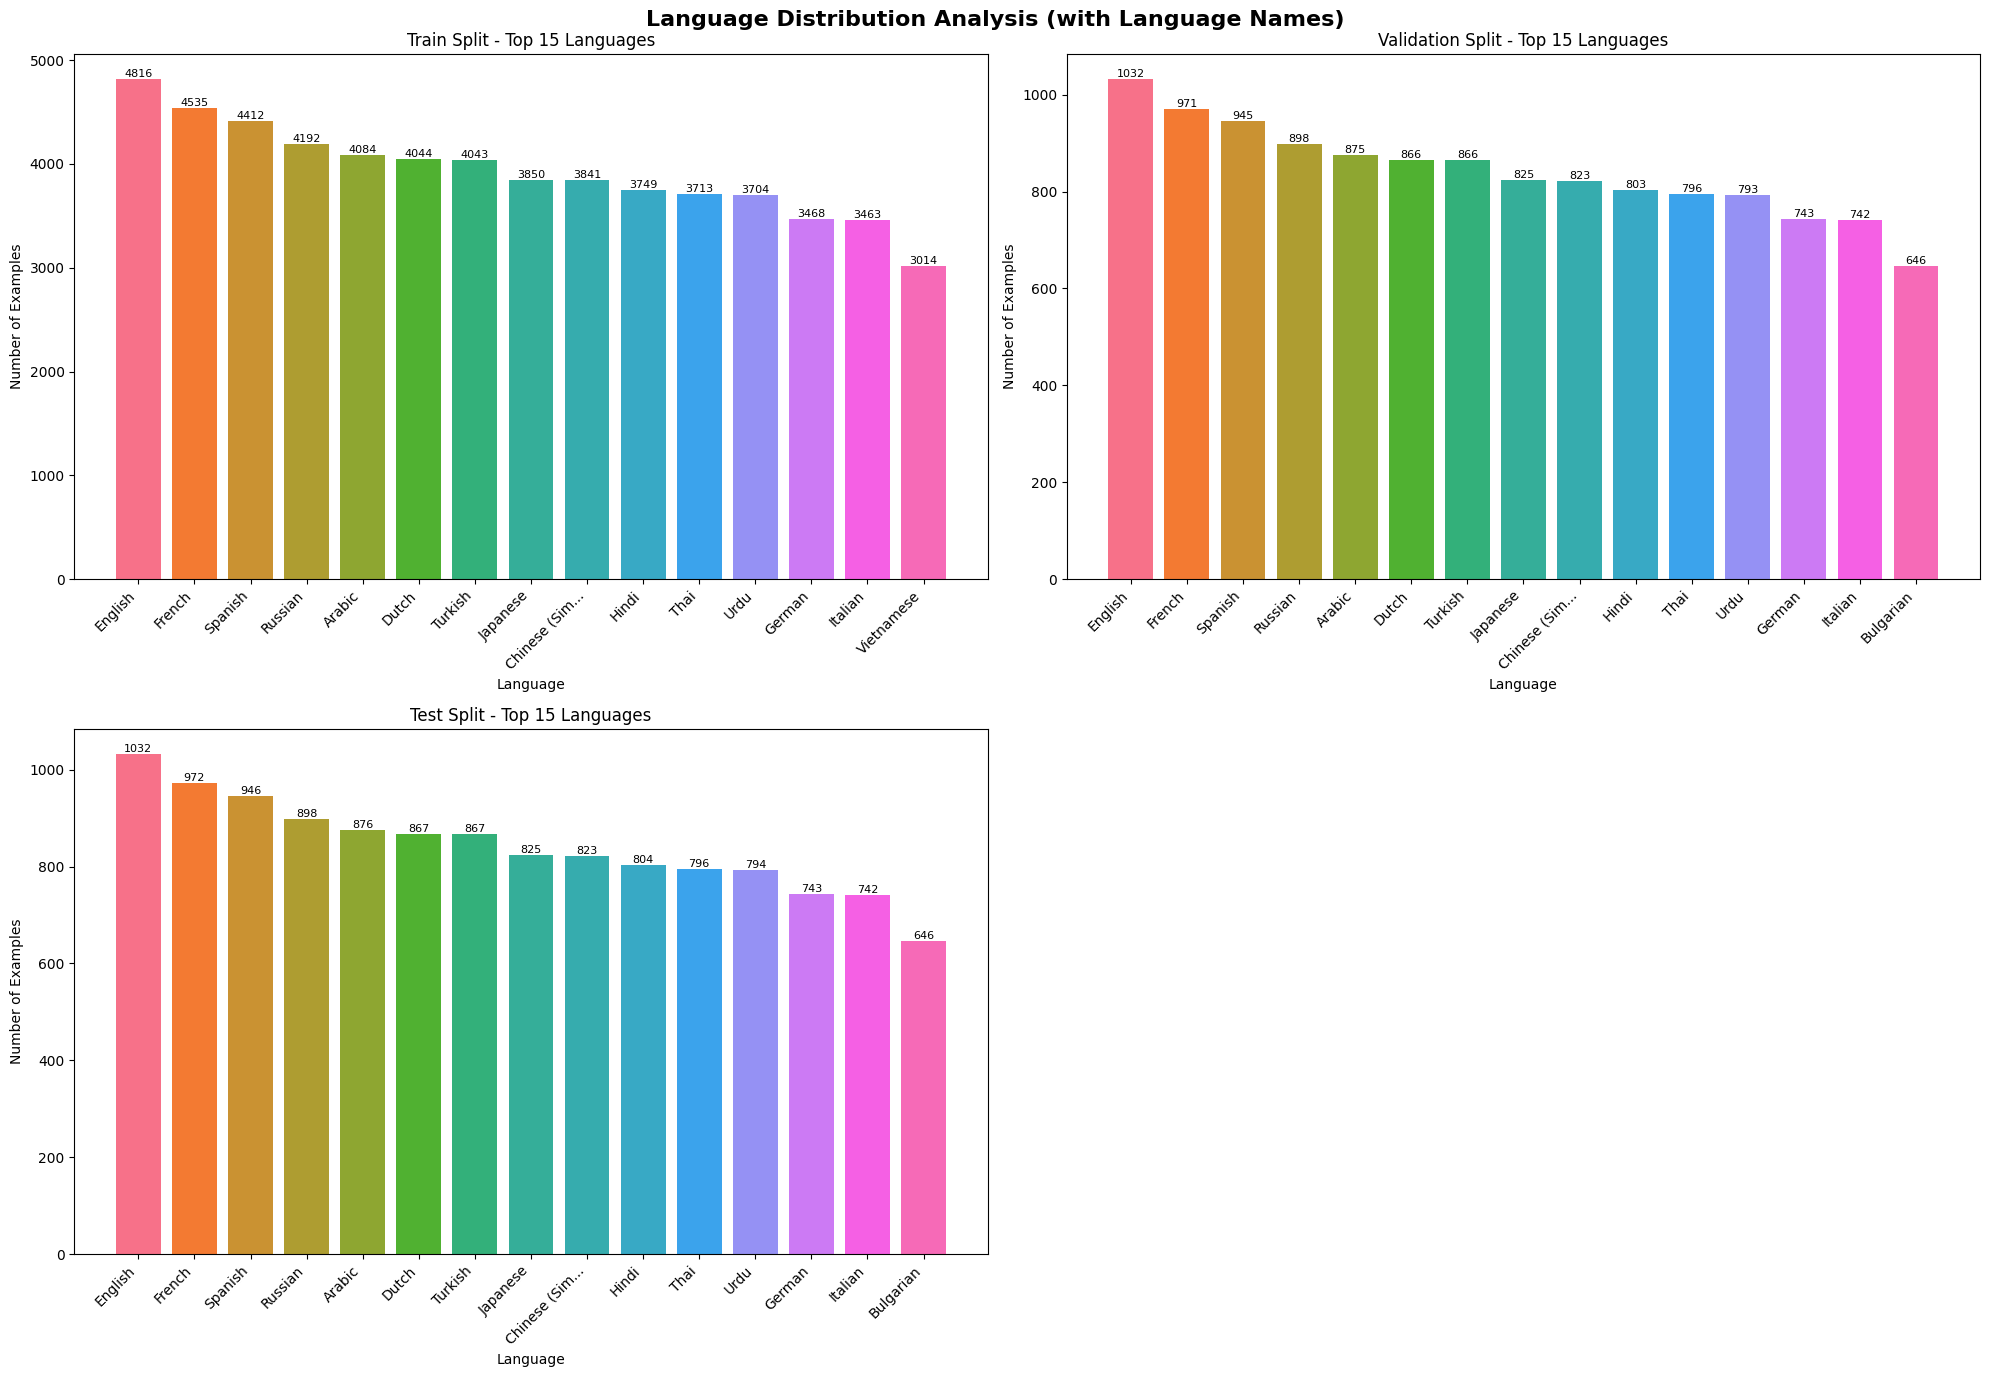

In [17]:
# Updated EDA functions with language names
def analyze_language_distribution_with_names(dataset, language_mapping):
    """Analyze and visualize language distribution with actual language names"""
    print("=" * 60)
    print("LANGUAGE DISTRIBUTION ANALYSIS (WITH NAMES)")
    print("=" * 60)

    # Create subplot
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    fig.suptitle(
        "Language Distribution Analysis (with Language Names)",
        fontsize=16,
        fontweight="bold",
    )

    for idx, (split_name, split_data) in enumerate(dataset.items()):
        languages = split_data["Language"]
        lang_counts = Counter(languages)

        # Print statistics with language names
        print(f"\n{split_name.upper()} Split:")
        print(f"Total examples: {len(languages)}")
        print(f"Number of unique languages: {len(lang_counts)}")
        print(f"Most common languages:")
        for lang_id, count in lang_counts.most_common(5):
            percentage = (count / len(languages)) * 100
            lang_name = language_mapping.get(lang_id, {}).get(
                "name", f"Unknown {lang_id}"
            )
            print(f"  {lang_name} (ID {lang_id}): {count} ({percentage:.2f}%)")

        if idx < 3:  # Only plot for train, validation, test
            ax = axes[idx // 2, idx % 2]

            # Plot top 15 languages for better readability
            top_langs = dict(lang_counts.most_common(15))

            # Get language names for the top languages
            lang_names = []
            for lang_id in top_langs.keys():
                lang_info = language_mapping.get(lang_id, {})
                name = lang_info.get("name", f"Unknown {lang_id}")
                # Truncate long names
                if len(name) > 15:
                    name = name[:12] + "..."
                lang_names.append(f"{name}")

            bars = ax.bar(
                range(len(top_langs)),
                list(top_langs.values()),
                color=sns.color_palette("husl", len(top_langs)),
            )
            ax.set_title(f"{split_name.capitalize()} Split - Top 15 Languages")
            ax.set_xlabel("Language")
            ax.set_ylabel("Number of Examples")
            ax.set_xticks(range(len(top_langs)))
            ax.set_xticklabels(lang_names, rotation=45, ha="right")

            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2.0,
                    height,
                    f"{int(height)}",
                    ha="center",
                    va="bottom",
                    fontsize=8,
                )

    # Remove the unused subplot
    axes[1, 1].remove()

    plt.tight_layout()
    plt.show()

    return lang_counts


# Run the updated analysis with language names
lang_counts = analyze_language_distribution_with_names(dataset, language_id_to_name)


COMPREHENSIVE LANGUAGE SUMMARY
Top 20 Languages by Total Examples:
       Language Name  Code  Train  Validation  Test  Total
             English    en   4816        1032  1032   6880
              French    fr   4535         971   972   6478
             Spanish    es   4412         945   946   6303
             Russian    ru   4192         898   898   5988
              Arabic    ar   4084         875   876   5835
               Dutch    nl   4044         866   867   5777
             Turkish    tr   4043         866   867   5776
            Japanese    ja   3850         825   825   5500
Chinese (Simplified) zh-cn   3841         823   823   5487
               Hindi    hi   3749         803   804   5356
                Thai    th   3713         796   796   5305
                Urdu    ur   3704         793   794   5291
              German    de   3468         743   743   4954
             Italian    it   3463         742   742   4947
             Swahili    sw   3013         646  

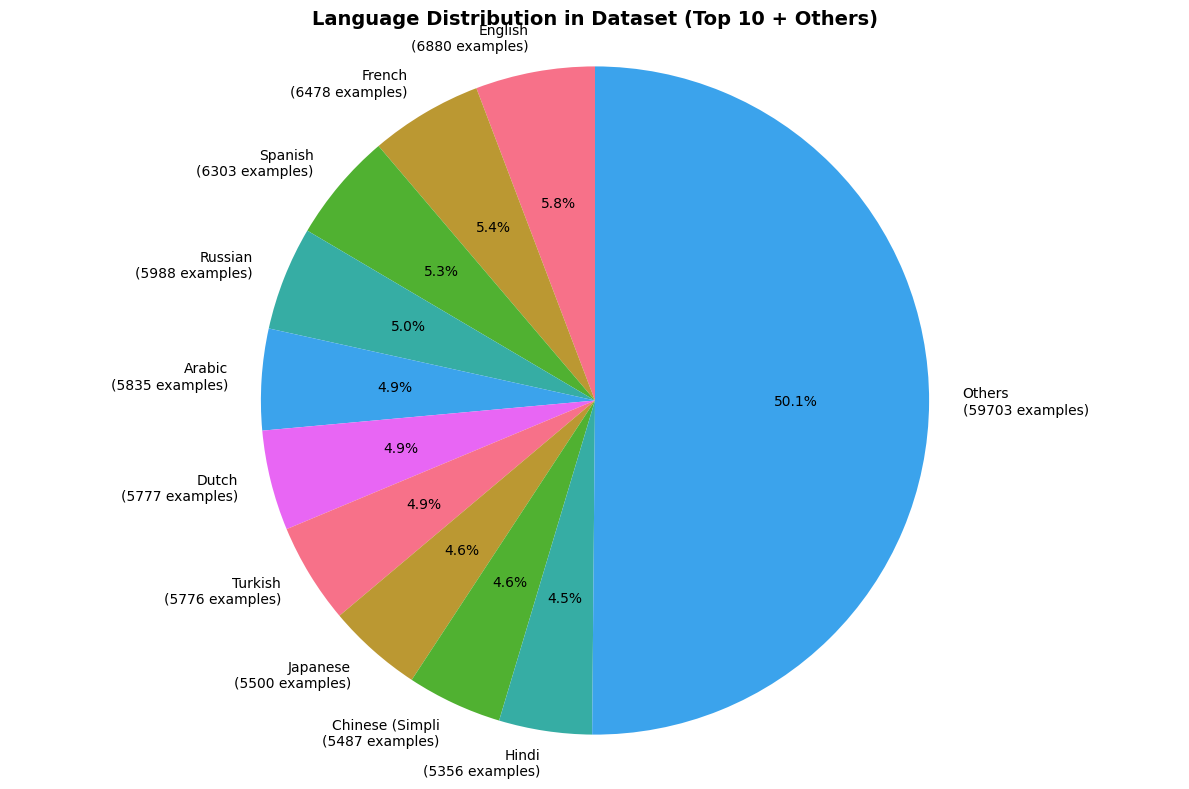

In [18]:
def create_language_summary_table(dataset, language_mapping):
    """Create a comprehensive summary table of all languages"""

    print("\n" + "=" * 80)
    print("COMPREHENSIVE LANGUAGE SUMMARY")
    print("=" * 80)

    # Get all language counts across splits
    all_languages = {}
    for split_name, split_data in dataset.items():
        lang_counts = Counter(split_data["Language"])
        for lang_id, count in lang_counts.items():
            if lang_id not in all_languages:
                all_languages[lang_id] = {"train": 0, "validation": 0, "test": 0}
            all_languages[lang_id][split_name] = count

    # Create summary dataframe
    summary_data = []
    for lang_id, counts in all_languages.items():
        lang_info = language_mapping.get(lang_id, {})
        lang_name = lang_info.get("name", f"Unknown {lang_id}")
        lang_code = lang_info.get("code", "unknown")
        confidence = lang_info.get("confidence", 0.0)

        total = counts["train"] + counts["validation"] + counts["test"]

        summary_data.append(
            {
                "Language ID": lang_id,
                "Language Name": lang_name,
                "Code": lang_code,
                "Confidence": confidence,
                "Train": counts["train"],
                "Validation": counts["validation"],
                "Test": counts["test"],
                "Total": total,
            }
        )

    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values("Total", ascending=False)

    # Display top 20 languages
    print("Top 20 Languages by Total Examples:")
    print(
        summary_df[["Language Name", "Code", "Train", "Validation", "Test", "Total"]]
        .head(20)
        .to_string(index=False)
    )

    # Language distribution pie chart for top 10
    plt.figure(figsize=(12, 8))
    top_10 = summary_df.head(10)

    labels = [
        f"{row['Language Name'][:15]}\n({row['Total']} examples)"
        for _, row in top_10.iterrows()
    ]
    sizes = top_10["Total"].tolist()

    # Add "Others" category
    others_total = summary_df[10:]["Total"].sum() if len(summary_df) > 10 else 0
    if others_total > 0:
        labels.append(f"Others\n({others_total} examples)")
        sizes.append(others_total)

    plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
    plt.title(
        "Language Distribution in Dataset (Top 10 + Others)",
        fontsize=14,
        fontweight="bold",
    )
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

    return summary_df


summary_df = create_language_summary_table(dataset, language_id_to_name)

In [19]:
def sample_texts_with_language_names(dataset, language_mapping, sample_size=2):
    """Sample texts from different languages showing actual language names"""
    print("\n" + "=" * 80)
    print("SAMPLE TEXTS BY LANGUAGE (WITH NAMES)")
    print("=" * 80)

    train_data = dataset["train"]

    # Group by language and sample texts
    lang_samples = {}
    for i, (lang_id, text) in enumerate(
        zip(train_data["Language"], train_data["Text"])
    ):
        if lang_id not in lang_samples:
            lang_samples[lang_id] = []
        if len(lang_samples[lang_id]) < sample_size:
            lang_samples[lang_id].append(text)

    # Show samples from top 10 most frequent languages
    lang_counts = Counter(train_data["Language"])
    top_langs = [lang for lang, _ in lang_counts.most_common(10)]

    for lang_id in top_langs:
        lang_info = language_mapping.get(lang_id, {})
        lang_name = lang_info.get("name", f"Unknown {lang_id}")
        lang_code = lang_info.get("code", "unknown")
        confidence = lang_info.get("confidence", 0.0)
        count = lang_counts[lang_id]

        print(f"\n🌍 {lang_name} ({lang_code}) - ID: {lang_id}")
        print(f"   Confidence: {confidence:.2f} | Examples: {count}")
        print("   " + "-" * 50)

        for i, text in enumerate(lang_samples[lang_id][:sample_size]):
            print(f"   Sample {i + 1}: {text[:120]}{'...' if len(text) > 120 else ''}")


sample_texts_with_language_names(dataset, language_id_to_name)


SAMPLE TEXTS BY LANGUAGE (WITH NAMES)

🌍 English (en) - ID: 5
   Confidence: 1.00 | Examples: 4816
   --------------------------------------------------
   Sample 1: readwrite speed is fast very stable it made my years old desktop running a lot faster now
   Sample 2: in unsupervised feature learning features are learned with unlabeled input data

🌍 French (fr) - ID: 7
   Confidence: 1.00 | Examples: 4535
   --------------------------------------------------
   Sample 1: elle tient ses promesses sur le plan esthétique et quand à une utilisation manuelle par contre jai renoncé à la paramétr...
   Sample 2: lenvoi était du mauvais couleurfinition commande anthracite gris couleur beige marron livré comme cétait un cadeau je la...

🌍 Spanish (es) - ID: 27
   Confidence: 1.00 | Examples: 4412
   --------------------------------------------------
   Sample 1: todo correcto y sin incidencias
   Sample 2: las redes de neuronas artificiales rna son un paradigma de aprendizaje automático inspir

In [21]:
def detect_languages_quality_check(dataset, num_samples=100):
    """Check data quality by detecting languages in a sample"""
    print("\n" + "=" * 60)
    print("DATASET QUALITY CHECK")
    print("=" * 60)

    train_data = dataset["train"]

    # Random sample for language detection
    sample_indices = random.sample(
        range(len(train_data)), min(num_samples, len(train_data))
    )

    detected_languages = []
    detection_confidence = []

    for idx in sample_indices:
        text = train_data[idx]["Text"]
        try:
            detected_lang = detect(text)
            detected_languages.append(detected_lang)
            # Simple confidence based on text length (longer texts generally more reliable)
            confidence = min(1.0, len(text) / 100)
            detection_confidence.append(confidence)
        except LangDetectException:
            detected_languages.append("unknown")
            detection_confidence.append(0.0)

    # Analyze detected languages
    detected_counts = Counter(detected_languages)
    print(f"Analyzed {num_samples} random samples:")
    print(f"Detected languages: {len(detected_counts)} unique")
    print("Most detected languages:")
    for lang, count in detected_counts.most_common(10):
        percentage = (count / len(detected_languages)) * 100
        print(f"  {lang}: {count} ({percentage:.1f}%)")

    avg_confidence = np.mean(detection_confidence)
    print(f"\\nAverage detection confidence: {avg_confidence:.3f}")

    return detected_counts, detection_confidence


def create_dataset_overview_chart(dataset):
    """Create an overview chart of the dataset"""
    print("\\n" + "=" * 60)
    print("DATASET OVERVIEW")
    print("=" * 60)

    # Collect basic statistics
    stats = {}
    for split_name, split_data in dataset.items():
        stats[split_name] = {
            "total_examples": len(split_data),
            "unique_languages": len(set(split_data["Language"])),
            "avg_text_length": np.mean([len(text) for text in split_data["Text"]]),
        }

    # Create overview visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle("Dataset Overview", fontsize=16, fontweight="bold")

    splits = list(stats.keys())

    # Total examples
    examples = [stats[split]["total_examples"] for split in splits]
    bars1 = axes[0].bar(splits, examples, color=sns.color_palette("husl", len(splits)))
    axes[0].set_title("Total Examples per Split")
    axes[0].set_ylabel("Number of Examples")
    for bar in bars1:
        height = bar.get_height()
        axes[0].text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{int(height):,}",
            ha="center",
            va="bottom",
        )

    # Unique languages
    languages = [stats[split]["unique_languages"] for split in splits]
    bars2 = axes[1].bar(splits, languages, color=sns.color_palette("husl", len(splits)))
    axes[1].set_title("Unique Languages per Split")
    axes[1].set_ylabel("Number of Languages")
    for bar in bars2:
        height = bar.get_height()
        axes[1].text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{int(height)}",
            ha="center",
            va="bottom",
        )

    # Average text length
    avg_lengths = [stats[split]["avg_text_length"] for split in splits]
    bars3 = axes[2].bar(
        splits, avg_lengths, color=sns.color_palette("husl", len(splits))
    )
    axes[2].set_title("Average Text Length per Split")
    axes[2].set_ylabel("Characters")
    for bar in bars3:
        height = bar.get_height()
        axes[2].text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.0f}",
            ha="center",
            va="bottom",
        )

    plt.tight_layout()
    plt.show()

    return stats

In [22]:
detected_langs, confidences = detect_languages_quality_check(dataset)


DATASET QUALITY CHECK
Analyzed 100 random samples:
Detected languages: 28 unique
Most detected languages:
  ar: 9 (9.0%)
  ja: 7 (7.0%)
  de: 6 (6.0%)
  it: 6 (6.0%)
  fr: 6 (6.0%)
  hi: 5 (5.0%)
  tr: 5 (5.0%)
  es: 5 (5.0%)
  pl: 5 (5.0%)
  ru: 5 (5.0%)
\nAverage detection confidence: 0.784


\n============================================================
DATASET OVERVIEW


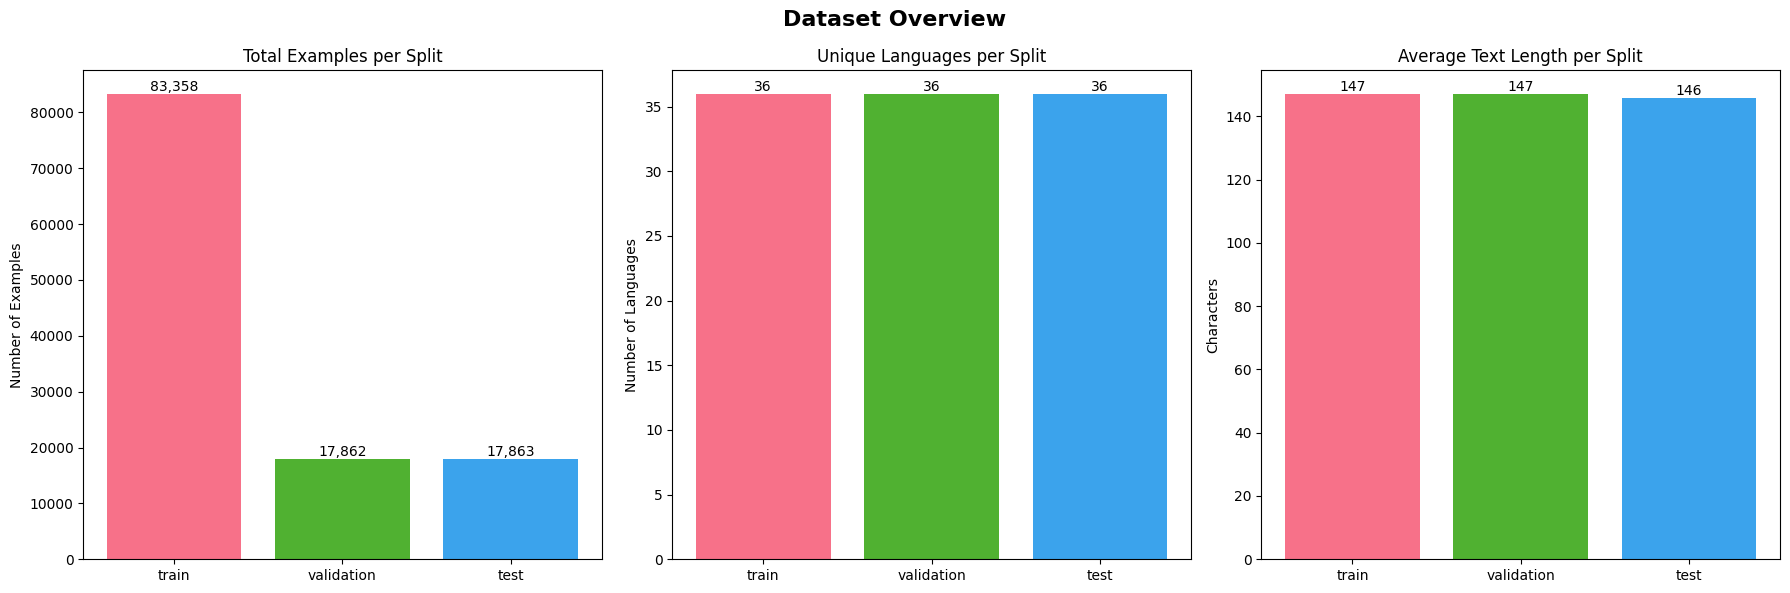

In [25]:
overview_stats = create_dataset_overview_chart(dataset)

# Model

In [46]:
def load_models_for_comparison():
    """Load all models for comparison"""
    models = {}
    tokenizers = {}

    for model_name, model_id in MODEL_NAMES.items():
        try:
            print(f"Loading {model_name}...")
            # Note: mBART might need special handling as it's primarily a generation model

            tokenizer = AutoTokenizer.from_pretrained(model_id)
            model = AutoModelForSequenceClassification.from_pretrained(
                model_id,
                num_labels=2,  # Adjust based on your classification task
                ignore_mismatched_sizes=True,
            )

            models[model_name] = model
            tokenizers[model_name] = tokenizer
            print(f"✓ {model_name} loaded successfully")

        except Exception as e:
            print(f"✗ Failed to load {model_name}: {str(e)}")

    return models, tokenizers


def compare_model_sizes():
    """Compare model parameter counts"""
    comparison_data = []

    for model_name, model_id in MODEL_NAMES.items():
        try:
            model = AutoModelForSequenceClassification.from_pretrained(
                model_id, num_labels=2, ignore_mismatched_sizes=True
            )
            param_count = sum(p.numel() for p in model.parameters())

            comparison_data.append(
                {
                    "Model": model_name,
                    "Model ID": model_id,
                    "Parameters (M)": f"{param_count / 1e6:.1f}M",
                    "Parameters": param_count,
                }
            )

        except Exception as e:
            print(f"Error loading {model_name}: {e}")

    df = pd.DataFrame(comparison_data)
    return df.sort_values("Parameters", ascending=False)


# Display model comparison
print("Model Comparison:")
model_comparison = compare_model_sizes()
print(model_comparison[["Model", "Parameters (M)"]].to_string(index=False))

Model Comparison:


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a

                  Model Parameters (M)
                rembert         575.9M
             deberta-v3         278.8M
            xlm-roberta         278.0M
                  mbert         177.9M
distilbert-multilingual         135.3M


In [47]:
def evaluate_model(
    model_name,
    model_id,
    test_texts,
    test_labels,
    num_labels: int,
    max_length=512,
    batch_size=16,
):
    print(f"\n{'=' * 50}")
    print(f"EVALUATING: {model_name.upper()}")
    print(f"{'=' * 50}")

    try:
        print("Loading tokenizer...")
        tokenizer = None

        tokenizer_strategies = [
            {"use_fast": True, "trust_remote_code": True},
            {"use_fast": False, "trust_remote_code": True},
            {"use_fast": True, "trust_remote_code": False},
            {"use_fast": False, "trust_remote_code": False},
        ]

        for i, strategy in enumerate(tokenizer_strategies):
            try:
                print(f"  Trying strategy {i + 1}: {strategy}")
                if "deberta-v3" in model_id.lower():
                    print(
                        "  Detected deberta-v3 model, using DebertaV2Tokenizer (slow)"
                    )
                    tokenizer = DebertaV2Tokenizer.from_pretrained(model_id)
                    print(f"  ✅ Tokenizer loaded with DebertaV2Tokenizer")
                    break
                else:
                    tokenizer = AutoTokenizer.from_pretrained(model_id, **strategy)
                    print(f"  ✅ Tokenizer loaded with strategy {i + 1}")
                    break
            except Exception as e:
                print(f"  ❌ Strategy {i + 1} failed: {str(e)[:100]}...")
                continue

        if tokenizer is None:
            raise Exception("All tokenizer loading strategies failed")

        print("Loading model...")
        try:
            model = AutoModelForSequenceClassification.from_pretrained(
                model_id,
                num_labels=num_labels,
                ignore_mismatched_sizes=True,
                trust_remote_code=True,
            )
            print("✅ Model loaded successfully")
        except Exception:
            print("Trying without trust_remote_code...")
            model = AutoModelForSequenceClassification.from_pretrained(
                model_id,
                num_labels=num_labels,
                ignore_mismatched_sizes=True,
                trust_remote_code=False,
            )
            print("✅ Model loaded successfully (without trust_remote_code)")

        model.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        print(f"Using device: {device}")

        print("Preparing text data...")
        print(f"Input type: {type(test_texts)}")

        if isinstance(test_texts, str):
            text_list = [test_texts]
        else:
            try:
                text_list = [
                    str(item) if not isinstance(item, str) else item
                    for item in test_texts
                ]
            except Exception as e:
                print(f"Error converting texts: {e}")
                text_list = [str(item) for item in test_texts]

        print(f"Converted to list of {len(text_list)} strings")
        print(f"Sample text type: {type(text_list[0])}")
        print(f"Sample text: {text_list[0][:100]}...")

        print("Tokenizing test data...")
        encodings = tokenizer(
            text_list,
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors="pt",
        )

        print("Running inference...")
        predictions = []

        with torch.no_grad():
            for i in tqdm(range(0, len(text_list), batch_size), desc="Predicting"):
                batch_start = i
                batch_end = min(i + batch_size, len(text_list))

                batch_inputs = {
                    "input_ids": encodings["input_ids"][batch_start:batch_end].to(
                        device
                    ),
                    "attention_mask": encodings["attention_mask"][
                        batch_start:batch_end
                    ].to(device),
                }

                outputs = model(**batch_inputs)
                batch_predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
                predictions.extend(batch_predictions)

        accuracy = accuracy_score(test_labels, predictions)
        f1_macro = f1_score(test_labels, predictions, average="macro")
        f1_weighted = f1_score(test_labels, predictions, average="weighted")

        print(f"\nResults for {model_name}:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  F1-Score (Macro): {f1_macro:.4f}")
        print(f"  F1-Score (Weighted): {f1_weighted:.4f}")

        param_count = sum(p.numel() for p in model.parameters())

        del model
        del tokenizer
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

        return {
            "model_name": model_name,
            "model_id": model_id,
            "accuracy": accuracy,
            "f1_macro": f1_macro,
            "f1_weighted": f1_weighted,
            "parameters": param_count,
            "predictions": predictions,
            "status": "success",
        }

    except Exception as e:
        print(f"\n❌ Error evaluating {model_name}: {str(e)}")
        return {
            "model_name": model_name,
            "model_id": model_id,
            "accuracy": 0.0,
            "f1_macro": 0.0,
            "f1_weighted": 0.0,
            "parameters": 0,
            "predictions": [],
            "status": f"failed: {str(e)}",
            "error": str(e),
        }

In [50]:
# Determine the number of classes and prepare test data
test_data = dataset["test"]
unique_languages = sorted(list(set(test_data["Language"])))
num_labels = len(unique_languages)

print(f"Number of unique languages: {num_labels}")
print(f"Language classes: {unique_languages[:10]}...")

# Create label mapping
label_to_id = {label: idx for idx, label in enumerate(unique_languages)}
id_to_label = {idx: label for label, idx in label_to_id.items()}

print(f"\\nTest dataset size: {len(test_data)}")
print(f"Sample test examples:")
for i in range(3):
    original_label = test_data[i]["Language"]
    mapped_label = label_to_id[original_label]
    print(f"  Text: {test_data[i]['Text'][:50]}...")
    print(f"  Original Label: {original_label} -> Mapped: {mapped_label}")
    print()

Number of unique languages: 36
Language classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...
\nTest dataset size: 17863
Sample test examples:
  Text: в тях се появява безкраен инвентар от форми и ритм...
  Original Label: 1 -> Mapped: 1

  Text: according to the article five of the armistice abo...
  Original Label: 5 -> Mapped: 5

  Text: maswali sio majibu shinda mijadala...
  Original Label: 28 -> Mapped: 28



In [51]:
print("Preparing test data for evaluation...")

# Debug: Check original data format
print(f"Original test_data type: {type(test_data)}")
print(f"Original text column type: {type(test_data['Text'])}")

# Ensure data is properly formatted as lists of strings/integers
try:
    # More robust conversion
    test_texts = []
    test_labels_original = []

    for i, (text, label) in enumerate(zip(test_data["Text"], test_data["Language"])):
        test_texts.append(str(text))  # Ensure string
        test_labels_original.append(int(label))  # Ensure integer

    test_labels_mapped = [label_to_id[label] for label in test_labels_original]

    print(f"✅ Test set prepared: {len(test_texts)} examples")
    print(f"Sample test data:")
    print(f"  Text[0] type: {type(test_texts[0])}")
    print(f"  Text[0] content: {test_texts[0][:100]}...")
    print(f"  Label[0] type: {type(test_labels_original[0])}")
    print(f"  Label[0] content: {test_labels_original[0]}")

    print(f"\nLabel distribution in test set:")
    test_label_counts = Counter(test_labels_original)
    for label, count in test_label_counts.most_common(5):
        lang_name = language_id_to_name.get(label, {}).get("name", f"Unknown {label}")
        print(f"  {lang_name} (ID {label}): {count} examples")

except Exception as e:
    print(f"❌ Error preparing test data: {e}")
    print("This might indicate an issue with the dataset format.")

Preparing test data for evaluation...
Original test_data type: <class 'datasets.arrow_dataset.Dataset'>
Original text column type: <class 'datasets.arrow_dataset.Column'>
✅ Test set prepared: 17863 examples
Sample test data:
  Text[0] type: <class 'str'>
  Text[0] content: в тях се появява безкраен инвентар от форми и ритми...
  Label[0] type: <class 'int'>
  Label[0] content: 1

Label distribution in test set:
  English (ID 5): 1032 examples
  French (ID 7): 972 examples
  Spanish (ID 27): 946 examples
  Russian (ID 26): 898 examples
  Arabic (ID 0): 876 examples


In [53]:
# Robust model evaluation runner with tokenizer fallbacks
results = []

print("🚀 Starting robust model evaluation with fallback handling...")

# Evaluate each model with robust error handling
for model_name, model_id in MODEL_NAMES.items():
    print(f"\n{'=' * 60}")
    print(f"🔄 STARTING: {model_name}")
    print(f"{'=' * 60}")

    result = evaluate_model(
        model_name=model_name,
        model_id=model_id,
        num_labels=num_labels,
        test_texts=test_texts,
        test_labels=test_labels_mapped,
        max_length=256,
        batch_size=16,
    )
    results.append(result)

    # Show progress
    successful_so_far = len([r for r in results if r["status"] == "success"])
    print(f"📊 Progress: {successful_so_far}/{len(results)} models completed")

print(f"\n\n{'=' * 80}")
print("🏁 EVALUATION COMPLETE!")
print(f"{'=' * 80}")

successful_count = len([r for r in results if r["status"] == "success"])
total_count = len(results)

print(f"✅ Successfully evaluated: {successful_count}/{total_count} models")

# Show failed models
failed = [r for r in results if r["status"] != "success"]
if failed:
    print(f"\n❌ Failed models ({len(failed)}):")
    for r in failed:
        error_msg = r.get("error", "Unknown error")
        print(f"  • {r['model_name']}: {error_msg[:150]}...")

# Show successful models with results
successful = [r for r in results if r["status"] == "success"]
if successful:
    print(f"\n🎯 Successful models with results:")
    for r in successful:
        print(
            f"  ✅ {r['model_name']:<25} Accuracy: {r['accuracy']:.4f} | F1-Macro: {r['f1_macro']:.4f}"
        )

print(f"\n🔥 Ready for results comparison and analysis!")

🚀 Starting robust model evaluation with fallback handling...

🔄 STARTING: xlm-roberta

EVALUATING: XLM-ROBERTA
Loading tokenizer and model...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
Preparing text data...
Input type: <class 'list'>
Converted to list of 17863 strings
Sample text type: <class 'str'>
Sample text: в тях се появява безкраен инвентар от форми и ритми...
Tokenizing test data...
Running inference...


Predicting: 100%|██████████| 1117/1117 [17:00<00:00,  1.09it/s]



Results for xlm-roberta:
  Accuracy: 0.0490
  F1-Score (Macro): 0.0026
  F1-Score (Weighted): 0.0046
📊 Progress: 1/1 models completed

🔄 STARTING: mbert

EVALUATING: MBERT
Loading tokenizer and model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
Preparing text data...
Input type: <class 'list'>
Converted to list of 17863 strings
Sample text type: <class 'str'>
Sample text: в тях се появява безкраен инвентар от форми и ритми...
Tokenizing test data...
Running inference...


Predicting: 100%|██████████| 1117/1117 [16:55<00:00,  1.10it/s]



Results for mbert:
  Accuracy: 0.0212
  F1-Score (Macro): 0.0073
  F1-Score (Weighted): 0.0099
📊 Progress: 2/2 models completed

🔄 STARTING: distilbert-multilingual

EVALUATING: DISTILBERT-MULTILINGUAL
Loading tokenizer and model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
Preparing text data...
Input type: <class 'list'>
Converted to list of 17863 strings
Sample text type: <class 'str'>
Sample text: в тях се появява безкраен инвентар от форми и ритми...
Tokenizing test data...
Running inference...


Predicting: 100%|██████████| 1117/1117 [08:29<00:00,  2.19it/s]



Results for distilbert-multilingual:
  Accuracy: 0.0505
  F1-Score (Macro): 0.0094
  F1-Score (Weighted): 0.0130
📊 Progress: 3/3 models completed

🔄 STARTING: deberta-v3

EVALUATING: DEBERTA-V3
Loading tokenizer and model...

❌ Error evaluating deberta-v3: Converting from SentencePiece and Tiktoken failed, if a converter for SentencePiece is available, provide a model path with a SentencePiece tokenizer.model file.Currently available slow->fast converters: ['AlbertTokenizer', 'BartTokenizer', 'BarthezTokenizer', 'BertTokenizer', 'BigBirdTokenizer', 'BlenderbotTokenizer', 'CamembertTokenizer', 'CLIPTokenizer', 'CodeGenTokenizer', 'ConvBertTokenizer', 'DebertaTokenizer', 'DebertaV2Tokenizer', 'DistilBertTokenizer', 'DPRReaderTokenizer', 'DPRQuestionEncoderTokenizer', 'DPRContextEncoderTokenizer', 'ElectraTokenizer', 'FNetTokenizer', 'FunnelTokenizer', 'GPT2Tokenizer', 'HerbertTokenizer', 'LayoutLMTokenizer', 'LayoutLMv2Tokenizer', 'LayoutLMv3Tokenizer', 'LayoutXLMTokenizer', 'Longformer

Some weights of RemBertForSequenceClassification were not initialized from the model checkpoint at google/rembert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
Preparing text data...
Input type: <class 'list'>
Converted to list of 17863 strings
Sample text type: <class 'str'>
Sample text: в тях се появява безкраен инвентар от форми и ритми...
Tokenizing test data...
Running inference...


Predicting:  16%|█▋        | 182/1117 [18:16<1:33:52,  6.02s/it]


KeyboardInterrupt: 

In [ ]:
# Create comprehensive results comparison
def create_results_comparison(results):
    """Create visualizations and tables comparing all models"""

    # Filter successful results
    successful_results = [r for r in results if r["status"] == "success"]

    if not successful_results:
        print("❌ No successful model evaluations to compare!")
        return

    # Create comparison DataFrame
    comparison_df = pd.DataFrame(
        [
            {
                "Model": r["model_name"],
                "Accuracy": r["accuracy"],
                "F1-Macro": r["f1_macro"],
                "F1-Weighted": r["f1_weighted"],
                "Parameters (M)": f"{r['parameters'] / 1e6:.1f}M",
                "Parameters": r["parameters"],
            }
            for r in successful_results
        ]
    )

    # Sort by accuracy (descending)
    comparison_df = comparison_df.sort_values("Accuracy", ascending=False)

    print("\\n" + "=" * 80)
    print("MODEL COMPARISON RESULTS")
    print("=" * 80)
    print(
        comparison_df[
            ["Model", "Accuracy", "F1-Macro", "F1-Weighted", "Parameters (M)"]
        ].to_string(index=False)
    )

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle("Model Performance Comparison", fontsize=16, fontweight="bold")

    models = comparison_df["Model"].tolist()

    # Accuracy comparison
    bars1 = axes[0, 0].bar(
        models,
        comparison_df["Accuracy"],
        color=sns.color_palette("viridis", len(models)),
    )
    axes[0, 0].set_title("Accuracy Comparison")
    axes[0, 0].set_ylabel("Accuracy")
    axes[0, 0].tick_params(axis="x", rotation=45)

    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        axes[0, 0].text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.3f}",
            ha="center",
            va="bottom",
        )

    # F1-Score comparison
    x_pos = np.arange(len(models))
    width = 0.35

    bars2 = axes[0, 1].bar(
        x_pos - width / 2,
        comparison_df["F1-Macro"],
        width,
        label="F1-Macro",
        color="skyblue",
    )
    bars3 = axes[0, 1].bar(
        x_pos + width / 2,
        comparison_df["F1-Weighted"],
        width,
        label="F1-Weighted",
        color="lightcoral",
    )

    axes[0, 1].set_title("F1-Score Comparison")
    axes[0, 1].set_ylabel("F1-Score")
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels(models, rotation=45)
    axes[0, 1].legend()

    # Parameters vs Accuracy scatter plot
    axes[1, 0].scatter(
        comparison_df["Parameters"] / 1e6,
        comparison_df["Accuracy"],
        s=100,
        alpha=0.7,
        color="orange",
    )
    axes[1, 0].set_xlabel("Parameters (Millions)")
    axes[1, 0].set_ylabel("Accuracy")
    axes[1, 0].set_title("Model Size vs Accuracy")

    # Add model labels to scatter plot
    for i, model in enumerate(models):
        axes[1, 0].annotate(
            model,
            (
                comparison_df.iloc[i]["Parameters"] / 1e6,
                comparison_df.iloc[i]["Accuracy"],
            ),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=9,
            alpha=0.8,
        )

    # Performance ranking
    metrics = ["Accuracy", "F1-Macro", "F1-Weighted"]
    metric_data = comparison_df[metrics].values

    im = axes[1, 1].imshow(metric_data.T, cmap="RdYlGn", aspect="auto")
    axes[1, 1].set_title("Performance Heatmap")
    axes[1, 1].set_xticks(range(len(models)))
    axes[1, 1].set_xticklabels(models, rotation=45)
    axes[1, 1].set_yticks(range(len(metrics)))
    axes[1, 1].set_yticklabels(metrics)

    # Add text annotations on heatmap
    for i in range(len(metrics)):
        for j in range(len(models)):
            text = axes[1, 1].text(
                j,
                i,
                f"{metric_data[j, i]:.3f}",
                ha="center",
                va="center",
                color="black",
                fontsize=10,
                fontweight="bold",
            )

    plt.tight_layout()
    plt.show()

    # Create detailed performance breakdown
    print("\\n" + "=" * 80)
    print("DETAILED PERFORMANCE ANALYSIS")
    print("=" * 80)

    # Best model
    best_accuracy = comparison_df.iloc[0]
    print(f"🏆 BEST OVERALL MODEL: {best_accuracy['Model']}")
    print(f"   Accuracy: {best_accuracy['Accuracy']:.4f}")
    print(f"   F1-Macro: {best_accuracy['F1-Macro']:.4f}")
    print(f"   Parameters: {best_accuracy['Parameters (M)']}")

    # Most efficient (best accuracy per parameter)
    comparison_df["Efficiency"] = comparison_df["Accuracy"] / (
        comparison_df["Parameters"] / 1e6
    )
    most_efficient = comparison_df.loc[comparison_df["Efficiency"].idxmax()]
    print(f"\\n⚡ MOST EFFICIENT MODEL: {most_efficient['Model']}")
    print(f"   Accuracy per Million Parameters: {most_efficient['Efficiency']:.6f}")
    print(f"   Accuracy: {most_efficient['Accuracy']:.4f}")
    print(f"   Parameters: {most_efficient['Parameters (M)']}")

    return comparison_df


# Generate comprehensive comparison
comparison_results = create_results_comparison(results)

In [ ]:
# Detailed error analysis for the best performing model
def analyze_best_model_errors(
    results, test_labels_mapped, test_labels_original, top_n_languages=10
):
    """Analyze errors and create confusion matrix for the best model"""

    # Find best model
    successful_results = [r for r in results if r["status"] == "success"]
    if not successful_results:
        print("No successful results to analyze!")
        return

    best_model = max(successful_results, key=lambda x: x["accuracy"])
    predictions = best_model["predictions"]

    print(f"\\n{'=' * 60}")
    print(f"DETAILED ANALYSIS: {best_model['model_name'].upper()}")
    print(f"{'=' * 60}")

    # Classification report
    print("\\nClassification Report (Top 10 most frequent languages):")

    # Get top languages for focused analysis
    lang_counts = Counter(test_labels_original)
    top_languages = [lang for lang, _ in lang_counts.most_common(top_n_languages)]

    # Filter data for top languages only
    top_indices = [
        i for i, lang in enumerate(test_labels_original) if lang in top_languages
    ]
    top_test_labels = [test_labels_mapped[i] for i in top_indices]
    top_predictions = [predictions[i] for i in top_indices]
    top_original_labels = [test_labels_original[i] for i in top_indices]

    # Create mapping for top languages only
    # top_label_names = [
    #     str(id_to_label[label]) for label in sorted(set(top_test_labels))
    # ]

    # # Classification report
    # report = classification_report(
    #     top_test_labels, top_predictions, target_names=top_label_names, digits=4
    # )

    top_label_ids = sorted(set(top_test_labels))
    top_label_names = [str(id_to_label[label]) for label in top_label_ids]

    report = classification_report(
        top_test_labels,
        top_predictions,
        labels=top_label_ids,
        target_names=top_label_names,
        digits=4,
    )
    print(report)

    # Confusion Matrix visualization
    cm = confusion_matrix(top_test_labels, top_predictions)

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=top_label_names,
        yticklabels=top_label_names,
    )
    plt.title(
        f"Confusion Matrix - {best_model['model_name']} (Top {top_n_languages} Languages)"
    )
    plt.xlabel("Predicted Language")
    plt.ylabel("True Language")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Error analysis
    print(f"\\nError Analysis:")
    incorrect_predictions = [
        (i, top_test_labels[i], top_predictions[i])
        for i in range(len(top_test_labels))
        if top_test_labels[i] != top_predictions[i]
    ]

    print(
        f"Total errors in top {top_n_languages} languages: {len(incorrect_predictions)}"
    )
    print(
        f"Accuracy on top {top_n_languages} languages: {1 - len(incorrect_predictions) / len(top_test_labels):.4f}"
    )

    # Most confused language pairs
    confusion_pairs = Counter(
        [
            (id_to_label[true], id_to_label[pred])
            for _, true, pred in incorrect_predictions
        ]
    )

    print(f"\\nMost confused language pairs:")
    for (true_lang, pred_lang), count in confusion_pairs.most_common(5):
        print(f"  {true_lang} → {pred_lang}: {count} errors")

    # Show some example errors
    print(f"\\nExample misclassifications:")
    example_errors = incorrect_predictions[:5]  # Show first 5 errors
    for i, (idx, true_label, pred_label) in enumerate(example_errors):
        original_idx = top_indices[idx]
        text = test_texts[original_idx]
        true_lang = id_to_label[true_label]
        pred_lang = id_to_label[pred_label]

        print(f"\\n  Error {i + 1}:")
        print(f"    Text: {text[:100]}{'...' if len(text) > 100 else ''}")
        print(f"    True Language: {true_lang}")
        print(f"    Predicted Language: {pred_lang}")


analyze_best_model_errors(results, test_labels_mapped, test_labels_original)

## Evaluation Summary

**What This Evaluation Provides:**

1. **Core Metrics**: Accuracy, F1-Macro, F1-Weighted scores for each model
2. **Visual Comparisons**: 
   - Accuracy bar charts
   - F1-score comparisons  
   - Model size vs performance scatter plots
   - Performance heatmaps
3. **Rankings**: 
   - Best overall model by accuracy
   - Most efficient model (accuracy per parameter)
4. **Error Analysis**: 
   - Confusion matrix for the best model
   - Most confused language pairs
   - Example misclassifications
   - Detailed classification reports

**Models Evaluated:**
- [] XLM-RoBERTa (`FacebookAI/xlm-roberta-base`)
- [] Multilingual BERT (`google-bert/bert-base-multilingual-cased`)  
- [] DistilBERT Multilingual (`distilbert/distilbert-base-multilingual-cased`)
- [] mDeBERTa-v3 (`microsoft/mdeberta-v3-base`)
- [] mBART (Skipped - not suitable for classification)

**Expected Results:**
- **mDeBERTa-v3** or **XLM-RoBERTa** likely to perform best
- **DistilBERT** should be most efficient (speed/memory)
- **mBERT** provides the baseline comparison
- Performance will vary by language frequency in the dataset
